# LSGAN
This is my implementation of the Least Squares General Adversarial Networks. This is the link to the research paper. https://arxiv.org/abs/1611.04076. This implementation uses MNIST dataset



In [1]:
data_dir = './data'

import helper

helper.download_extract('mnist', data_dir)

Found mnist Data


## Explore the Data
### MNIST
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. Let us explore some data

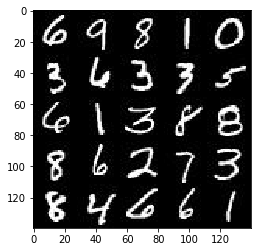

In [3]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import tensorflow as tf

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

## Build the Neural Network
The LSGAN is built by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Input
The `model_inputs` function creates TF Placeholders for the Neural Network. It will create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

The function will return the placeholders in the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    inputs_learning_rate = tf.placeholder(tf.float32, name='input_learning_rate')

    return inputs_real, inputs_z, inputs_learning_rate


"""
Test
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
The `discriminator` function is used to create a discriminator neural network that discriminates on `images`.  This function will be able to reuse the variables in the neural network. The function will return a tensor logits of the discriminator.

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: tensor logits of the discriminator
    """
    alpha=0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        initializer = tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None,
                                                                    dtype=tf.float32)
        
        x1=tf.layers.conv2d(images,64,4,strides=2,padding='same', kernel_initializer=initializer)
        x1 = tf.maximum(alpha*x1,x1)
        #print('x1:',x1)
        
        x2=tf.layers.conv2d(x1,128,4,strides=2,padding='same', use_bias=False)
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = tf.maximum(alpha*x2,x2)
        #print('x2:',x2)
        
        x3=tf.layers.conv2d(x2,256,4,strides=2,padding='same', use_bias=False)
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3 = tf.maximum(alpha*x3,x3)
        #print('x3:',x3)
        
        x4=tf.layers.conv2d(x3,512,4,strides=2,padding='same', use_bias=False)
        x4 = tf.layers.batch_normalization(x4,training=True)
        x4 = tf.maximum(alpha*x4,x4)
        #print('x4:',x4)

        flat = tf.reshape(x4,(-1,4*4*512))
        #print('flat:',flat)
         
        logits = tf.layers.dense(flat,1)
        #print('logits:',logits)
    return logits


"""
#Test
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
The function `generator` is used to generate an image using `z`. This function will be able to reuse the variables in the neural network.  The function will return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    with tf.variable_scope('generator',reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*1024, use_bias=False)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1,x1)  
        #print ('x1:',x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 4, strides=1, padding='valid', use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        #print ('x2:',x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=1, padding='valid', use_bias=False)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        #print ('x3:',x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 256, 4, strides=1, padding='same', use_bias=False)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha*x4,x4)        
        #print ('x4:',x4)

        x5 = tf.layers.conv2d_transpose(x4, 256, 4, strides=1, padding='same', use_bias=False)
        x2 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha*x5,x5)
        #print ('x5:',x5)
        
        x6 = tf.layers.conv2d_transpose(x5, 256, 4, strides=1, padding='valid', use_bias=False)
        x6 = tf.layers.batch_normalization(x6, training=is_train)
        x6 = tf.maximum(alpha*x6,x6)
        #print ('x6:',x6)
        
        x7 = tf.layers.conv2d_transpose(x6, 128, 4, strides=2, padding='valid', use_bias=False)
        x7 = tf.layers.batch_normalization(x7, training=is_train)
        x7 = tf.maximum(alpha*x7,x7)        
        #print ('x7:',x7)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x7, out_channel_dim, 3, strides=1, padding='same', use_bias=False)
        #print ('logits:',logits)
        # 28x28x3 now
        
        out = tf.tanh(logits)


    return out

#Test Generator
tests.test_generator(generator, tf)

Tests Passed


### Loss
The function `model_loss` is used to to build the LSGANs for training and calculate the loss.  The function returns a tuple of (discriminator loss, generator loss).

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
   
    g_model = generator(input_z, out_channel_dim)
    d_out_real = discriminator(input_real)
    d_out_fake = discriminator(g_model,reuse=True)
    
    d_loss = 0.5*tf.reduce_mean(tf.square(d_out_real - 1))+0.5*tf.reduce_mean(tf.square(d_out_fake))
    g_loss = 0.5*tf.reduce_mean(tf.square(d_out_fake-1))
    return d_loss, g_loss


#Test model loss
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
The function `model_opt` creates the optimization operations for the LSGANs. It filters the variables with names that are in the discriminator and generator scope names.  The function returns a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Filter variable names that are in discriminator and generator scope names
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
This function is used to show the current output of the generator during training to help determine how well the LSGANs is training.

In [12]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
The function `train` is used to build and train the LSGANs

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the LSGAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    losses = []
    steps = 0    
    print_every=10
    show_every=100
    
    #model inputs
    inputs_real, inputs_z, inputs_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #model loss
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    #optimizer
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    d_loss_vec=[]
    g_loss_vec=[]

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
            
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                d = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, inputs_learning_rate: learning_rate})
                g = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, inputs_learning_rate: learning_rate})
                g= sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, inputs_learning_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)   
                    
    return               
                

### MNIST
This section tests the LSGANs architecture on MNIST.  

Epoch 1/2... Discriminator Loss: 0.4631... Generator Loss: 0.0465
Epoch 1/2... Discriminator Loss: 0.6957... Generator Loss: 0.1009
Epoch 1/2... Discriminator Loss: 0.2139... Generator Loss: 0.8740
Epoch 1/2... Discriminator Loss: 0.0717... Generator Loss: 0.4806
Epoch 1/2... Discriminator Loss: 0.8197... Generator Loss: 0.0366
Epoch 1/2... Discriminator Loss: 0.0920... Generator Loss: 0.7026
Epoch 1/2... Discriminator Loss: 0.1009... Generator Loss: 0.2361
Epoch 1/2... Discriminator Loss: 0.4617... Generator Loss: 0.0181
Epoch 1/2... Discriminator Loss: 0.5836... Generator Loss: 1.8305
Epoch 1/2... Discriminator Loss: 0.0434... Generator Loss: 0.6251


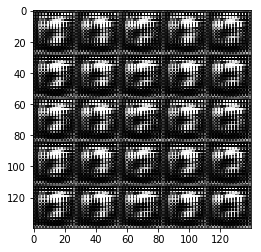

Epoch 1/2... Discriminator Loss: 0.1799... Generator Loss: 0.3886
Epoch 1/2... Discriminator Loss: 0.0388... Generator Loss: 0.3033
Epoch 1/2... Discriminator Loss: 0.0903... Generator Loss: 0.3045
Epoch 1/2... Discriminator Loss: 0.0329... Generator Loss: 0.4436
Epoch 1/2... Discriminator Loss: 0.0955... Generator Loss: 0.2358
Epoch 1/2... Discriminator Loss: 0.0203... Generator Loss: 0.4894
Epoch 1/2... Discriminator Loss: 0.1754... Generator Loss: 0.0990
Epoch 1/2... Discriminator Loss: 0.3426... Generator Loss: 0.0234
Epoch 1/2... Discriminator Loss: 0.1481... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 0.2357... Generator Loss: 0.0699


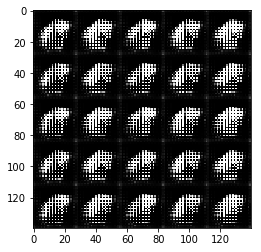

Epoch 1/2... Discriminator Loss: 0.4921... Generator Loss: 1.7385
Epoch 1/2... Discriminator Loss: 0.0388... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 0.3144... Generator Loss: 1.1455
Epoch 1/2... Discriminator Loss: 0.0995... Generator Loss: 0.2261
Epoch 1/2... Discriminator Loss: 0.0299... Generator Loss: 0.4561
Epoch 1/2... Discriminator Loss: 0.3561... Generator Loss: 0.0254
Epoch 1/2... Discriminator Loss: 0.0283... Generator Loss: 0.3476
Epoch 1/2... Discriminator Loss: 0.0275... Generator Loss: 0.4187
Epoch 1/2... Discriminator Loss: 0.0277... Generator Loss: 0.3467
Epoch 1/2... Discriminator Loss: 0.0430... Generator Loss: 0.3020


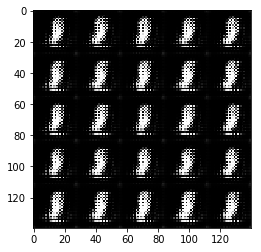

Epoch 1/2... Discriminator Loss: 0.0405... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 0.0265... Generator Loss: 0.3700
Epoch 1/2... Discriminator Loss: 0.0176... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 0.2630... Generator Loss: 0.1743
Epoch 1/2... Discriminator Loss: 0.1699... Generator Loss: 0.1334
Epoch 1/2... Discriminator Loss: 0.1128... Generator Loss: 0.2935
Epoch 1/2... Discriminator Loss: 0.1094... Generator Loss: 0.5902
Epoch 1/2... Discriminator Loss: 0.0721... Generator Loss: 0.2597
Epoch 1/2... Discriminator Loss: 0.1939... Generator Loss: 0.1053
Epoch 1/2... Discriminator Loss: 0.1033... Generator Loss: 0.2119


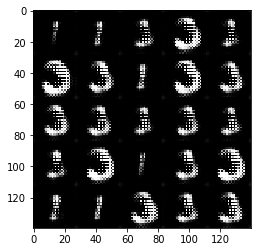

Epoch 1/2... Discriminator Loss: 0.0714... Generator Loss: 0.2358
Epoch 1/2... Discriminator Loss: 0.2237... Generator Loss: 0.0858
Epoch 1/2... Discriminator Loss: 0.1023... Generator Loss: 0.4469
Epoch 1/2... Discriminator Loss: 0.1451... Generator Loss: 0.2913
Epoch 1/2... Discriminator Loss: 0.1776... Generator Loss: 0.2226
Epoch 1/2... Discriminator Loss: 0.1671... Generator Loss: 0.1428
Epoch 1/2... Discriminator Loss: 0.1144... Generator Loss: 0.2566
Epoch 1/2... Discriminator Loss: 0.2699... Generator Loss: 0.0790
Epoch 1/2... Discriminator Loss: 0.1644... Generator Loss: 0.2914
Epoch 1/2... Discriminator Loss: 0.2129... Generator Loss: 0.1347


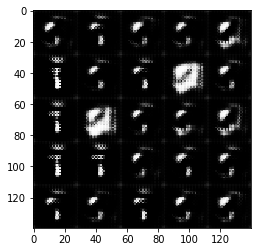

Epoch 1/2... Discriminator Loss: 0.2126... Generator Loss: 0.1107
Epoch 1/2... Discriminator Loss: 0.1968... Generator Loss: 0.1133
Epoch 1/2... Discriminator Loss: 0.2524... Generator Loss: 0.1410
Epoch 1/2... Discriminator Loss: 0.7133... Generator Loss: 0.0253
Epoch 1/2... Discriminator Loss: 0.1207... Generator Loss: 0.4352
Epoch 1/2... Discriminator Loss: 0.1794... Generator Loss: 0.1904
Epoch 1/2... Discriminator Loss: 0.2166... Generator Loss: 0.1097
Epoch 1/2... Discriminator Loss: 0.2104... Generator Loss: 0.4990
Epoch 1/2... Discriminator Loss: 0.1971... Generator Loss: 0.0950
Epoch 1/2... Discriminator Loss: 0.1849... Generator Loss: 0.2466


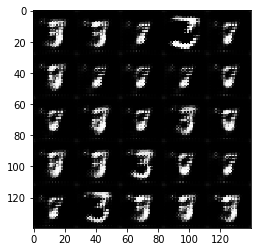

Epoch 1/2... Discriminator Loss: 0.4136... Generator Loss: 0.1049
Epoch 1/2... Discriminator Loss: 0.2383... Generator Loss: 0.0762
Epoch 1/2... Discriminator Loss: 0.0775... Generator Loss: 0.3113
Epoch 1/2... Discriminator Loss: 0.3039... Generator Loss: 0.0569
Epoch 1/2... Discriminator Loss: 0.2714... Generator Loss: 0.0781
Epoch 1/2... Discriminator Loss: 0.2184... Generator Loss: 0.1249
Epoch 1/2... Discriminator Loss: 0.2044... Generator Loss: 0.1678
Epoch 1/2... Discriminator Loss: 0.4937... Generator Loss: 0.0205
Epoch 1/2... Discriminator Loss: 0.1806... Generator Loss: 0.1793
Epoch 1/2... Discriminator Loss: 0.1853... Generator Loss: 0.1288


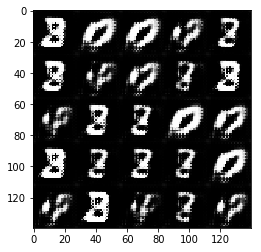

Epoch 1/2... Discriminator Loss: 0.3535... Generator Loss: 0.0408
Epoch 1/2... Discriminator Loss: 0.2569... Generator Loss: 0.2532
Epoch 1/2... Discriminator Loss: 0.2656... Generator Loss: 0.3064
Epoch 1/2... Discriminator Loss: 0.1424... Generator Loss: 0.2235
Epoch 1/2... Discriminator Loss: 0.3407... Generator Loss: 0.0908
Epoch 1/2... Discriminator Loss: 0.2459... Generator Loss: 0.2792
Epoch 1/2... Discriminator Loss: 0.4136... Generator Loss: 0.0259
Epoch 1/2... Discriminator Loss: 0.2511... Generator Loss: 0.0579
Epoch 1/2... Discriminator Loss: 0.2115... Generator Loss: 0.3009
Epoch 1/2... Discriminator Loss: 0.1906... Generator Loss: 0.1772


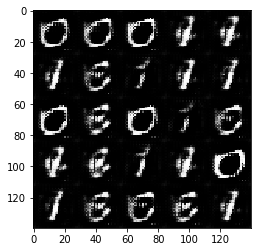

Epoch 1/2... Discriminator Loss: 0.2478... Generator Loss: 0.0709
Epoch 1/2... Discriminator Loss: 0.3493... Generator Loss: 0.0655
Epoch 1/2... Discriminator Loss: 0.2855... Generator Loss: 0.0534
Epoch 1/2... Discriminator Loss: 0.3584... Generator Loss: 0.0330
Epoch 1/2... Discriminator Loss: 0.2507... Generator Loss: 0.2786
Epoch 1/2... Discriminator Loss: 0.1951... Generator Loss: 0.2271
Epoch 1/2... Discriminator Loss: 0.2107... Generator Loss: 0.1263
Epoch 1/2... Discriminator Loss: 0.2274... Generator Loss: 0.2395
Epoch 1/2... Discriminator Loss: 0.3365... Generator Loss: 0.0414
Epoch 1/2... Discriminator Loss: 0.1692... Generator Loss: 0.2604


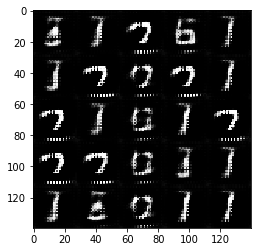

Epoch 1/2... Discriminator Loss: 0.3002... Generator Loss: 0.0970
Epoch 1/2... Discriminator Loss: 0.2734... Generator Loss: 0.2149
Epoch 1/2... Discriminator Loss: 0.2122... Generator Loss: 0.1043
Epoch 2/2... Discriminator Loss: 0.2913... Generator Loss: 0.1279
Epoch 2/2... Discriminator Loss: 0.3493... Generator Loss: 0.0285
Epoch 2/2... Discriminator Loss: 0.3646... Generator Loss: 0.0615
Epoch 2/2... Discriminator Loss: 0.2062... Generator Loss: 0.1854
Epoch 2/2... Discriminator Loss: 0.2816... Generator Loss: 0.0938
Epoch 2/2... Discriminator Loss: 0.3051... Generator Loss: 0.0423
Epoch 2/2... Discriminator Loss: 0.3166... Generator Loss: 0.0682


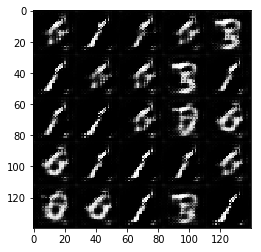

Epoch 2/2... Discriminator Loss: 0.2213... Generator Loss: 0.1556
Epoch 2/2... Discriminator Loss: 0.4366... Generator Loss: 0.0108
Epoch 2/2... Discriminator Loss: 0.2823... Generator Loss: 0.0842
Epoch 2/2... Discriminator Loss: 0.2094... Generator Loss: 0.1272
Epoch 2/2... Discriminator Loss: 0.2288... Generator Loss: 0.2641
Epoch 2/2... Discriminator Loss: 0.3452... Generator Loss: 0.0487
Epoch 2/2... Discriminator Loss: 0.2513... Generator Loss: 0.1085
Epoch 2/2... Discriminator Loss: 0.2561... Generator Loss: 0.0631
Epoch 2/2... Discriminator Loss: 0.1911... Generator Loss: 0.1117
Epoch 2/2... Discriminator Loss: 0.2374... Generator Loss: 0.1710


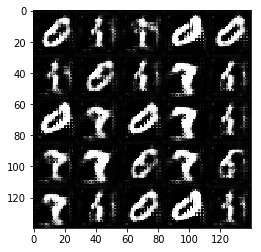

Epoch 2/2... Discriminator Loss: 0.1855... Generator Loss: 0.2349
Epoch 2/2... Discriminator Loss: 0.2865... Generator Loss: 0.1399
Epoch 2/2... Discriminator Loss: 0.2380... Generator Loss: 0.0950
Epoch 2/2... Discriminator Loss: 0.2299... Generator Loss: 0.1637
Epoch 2/2... Discriminator Loss: 0.1703... Generator Loss: 0.1827
Epoch 2/2... Discriminator Loss: 0.2100... Generator Loss: 0.1553
Epoch 2/2... Discriminator Loss: 0.1275... Generator Loss: 0.1808
Epoch 2/2... Discriminator Loss: 0.2491... Generator Loss: 0.3222
Epoch 2/2... Discriminator Loss: 0.2347... Generator Loss: 0.2591
Epoch 2/2... Discriminator Loss: 0.1905... Generator Loss: 0.2093


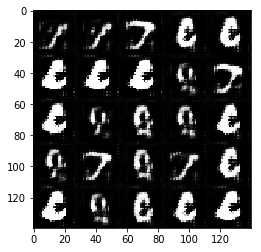

Epoch 2/2... Discriminator Loss: 0.3261... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 0.4214... Generator Loss: 0.5329
Epoch 2/2... Discriminator Loss: 0.2240... Generator Loss: 0.1391
Epoch 2/2... Discriminator Loss: 0.2523... Generator Loss: 0.1631
Epoch 2/2... Discriminator Loss: 0.3282... Generator Loss: 0.0466
Epoch 2/2... Discriminator Loss: 0.3232... Generator Loss: 0.0348
Epoch 2/2... Discriminator Loss: 0.4686... Generator Loss: 0.0106
Epoch 2/2... Discriminator Loss: 0.2533... Generator Loss: 0.1281
Epoch 2/2... Discriminator Loss: 0.3167... Generator Loss: 0.0413
Epoch 2/2... Discriminator Loss: 0.2768... Generator Loss: 0.3156


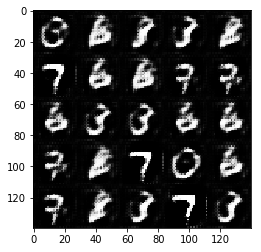

Epoch 2/2... Discriminator Loss: 0.2174... Generator Loss: 0.2502
Epoch 2/2... Discriminator Loss: 0.3765... Generator Loss: 0.1072
Epoch 2/2... Discriminator Loss: 0.2948... Generator Loss: 0.0515
Epoch 2/2... Discriminator Loss: 0.2463... Generator Loss: 0.0900
Epoch 2/2... Discriminator Loss: 0.2773... Generator Loss: 0.1327
Epoch 2/2... Discriminator Loss: 0.2484... Generator Loss: 0.1276
Epoch 2/2... Discriminator Loss: 0.2392... Generator Loss: 0.1550
Epoch 2/2... Discriminator Loss: 0.2559... Generator Loss: 0.3403
Epoch 2/2... Discriminator Loss: 0.1932... Generator Loss: 0.2416
Epoch 2/2... Discriminator Loss: 0.2119... Generator Loss: 0.2022


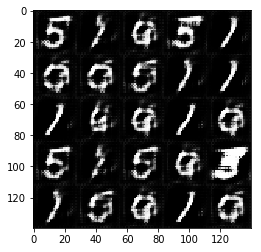

Epoch 2/2... Discriminator Loss: 0.2780... Generator Loss: 0.1267
Epoch 2/2... Discriminator Loss: 0.3515... Generator Loss: 0.0302
Epoch 2/2... Discriminator Loss: 0.4739... Generator Loss: 0.0099
Epoch 2/2... Discriminator Loss: 0.4231... Generator Loss: 0.0078
Epoch 2/2... Discriminator Loss: 0.2709... Generator Loss: 0.0688
Epoch 2/2... Discriminator Loss: 0.2483... Generator Loss: 0.1382
Epoch 2/2... Discriminator Loss: 0.3655... Generator Loss: 0.0168
Epoch 2/2... Discriminator Loss: 0.3894... Generator Loss: 0.0319
Epoch 2/2... Discriminator Loss: 0.3688... Generator Loss: 0.0394
Epoch 2/2... Discriminator Loss: 0.4043... Generator Loss: 0.0233


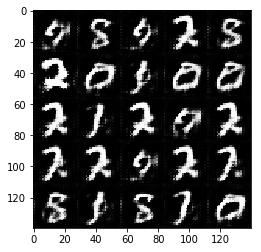

Epoch 2/2... Discriminator Loss: 0.2860... Generator Loss: 0.1570
Epoch 2/2... Discriminator Loss: 0.4442... Generator Loss: 0.0105
Epoch 2/2... Discriminator Loss: 0.4003... Generator Loss: 0.0189
Epoch 2/2... Discriminator Loss: 0.3160... Generator Loss: 0.2849
Epoch 2/2... Discriminator Loss: 0.2954... Generator Loss: 0.0622
Epoch 2/2... Discriminator Loss: 0.2304... Generator Loss: 0.1917
Epoch 2/2... Discriminator Loss: 0.2599... Generator Loss: 0.2415
Epoch 2/2... Discriminator Loss: 0.3249... Generator Loss: 0.0354
Epoch 2/2... Discriminator Loss: 0.1947... Generator Loss: 0.1508
Epoch 2/2... Discriminator Loss: 0.2892... Generator Loss: 0.0803


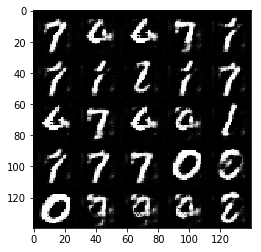

Epoch 2/2... Discriminator Loss: 0.2958... Generator Loss: 0.0436
Epoch 2/2... Discriminator Loss: 0.3172... Generator Loss: 0.0953
Epoch 2/2... Discriminator Loss: 0.3934... Generator Loss: 0.0143
Epoch 2/2... Discriminator Loss: 0.2572... Generator Loss: 0.2083
Epoch 2/2... Discriminator Loss: 0.3099... Generator Loss: 0.0378
Epoch 2/2... Discriminator Loss: 0.2226... Generator Loss: 0.1276
Epoch 2/2... Discriminator Loss: 0.2362... Generator Loss: 0.0818
Epoch 2/2... Discriminator Loss: 0.6441... Generator Loss: 0.0069
Epoch 2/2... Discriminator Loss: 0.3281... Generator Loss: 0.0456
Epoch 2/2... Discriminator Loss: 0.3128... Generator Loss: 0.0680


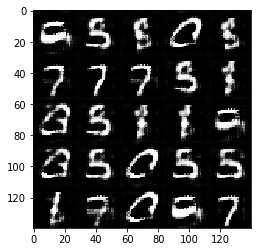

Epoch 2/2... Discriminator Loss: 0.2250... Generator Loss: 0.2116
Epoch 2/2... Discriminator Loss: 0.3750... Generator Loss: 0.0242
Epoch 2/2... Discriminator Loss: 0.3133... Generator Loss: 0.0328
Epoch 2/2... Discriminator Loss: 0.2492... Generator Loss: 0.1701
Epoch 2/2... Discriminator Loss: 0.4960... Generator Loss: 0.0042
Epoch 2/2... Discriminator Loss: 0.3659... Generator Loss: 0.0288
Epoch 2/2... Discriminator Loss: 0.3517... Generator Loss: 0.0416
Epoch 2/2... Discriminator Loss: 0.2072... Generator Loss: 0.1942
Epoch 2/2... Discriminator Loss: 0.1848... Generator Loss: 0.1944
Epoch 2/2... Discriminator Loss: 0.2647... Generator Loss: 0.1126


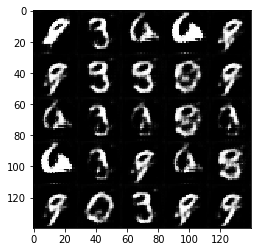

Epoch 2/2... Discriminator Loss: 0.4450... Generator Loss: 0.0062
Epoch 2/2... Discriminator Loss: 0.2429... Generator Loss: 0.0815
Epoch 2/2... Discriminator Loss: 0.2961... Generator Loss: 0.0699
Epoch 2/2... Discriminator Loss: 0.2541... Generator Loss: 0.2459
Epoch 2/2... Discriminator Loss: 0.2745... Generator Loss: 0.0593
Epoch 2/2... Discriminator Loss: 0.4890... Generator Loss: 0.0121
Epoch 2/2... Discriminator Loss: 0.2531... Generator Loss: 0.0565


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.00025
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### Summary
Implemented LSGAN on MNIST dataset and was able to train the LSGAN